In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)



# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)
    

# Dataset used
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self, sims, unmask_size=20, points = None, block_size = 50, reveal_strategy = "block", n_points = 20, radius = 2, steps = None, H=200, W=200, channels="all", noise = 5):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.noise = noise

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    def __getitem__(self, index):
        if not type(self.steps) == np.ndarray:
            step = np.random.randint(1,200)
        else:
            step = self.steps[index]

        # Create tensor for the target
        t = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":
            ii = torch.randint(0, self.H, (self.n_points,))
            jj = torch.randint(0, self.W, (self.n_points,))
            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk

        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t[chans].clone()
        # Add Gausian noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)




        # write revealed pixels for selected channels
        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))

        return z,t
    
    def __len__(self):
        return self.sims.shape[0]
    

In [32]:
torch.manual_seed(123); np.random.seed(123)

def vis(tensor):
    return tensor.cpu().detach().numpy()

def show_evaluation(model, indices, val_data):

    fig, axs = plt.subplots(len(indices), 6, dpi=600)

    axs[0,0].set_title("Given K", fontsize=8)
    axs[0,1].set_title("Predicted K",fontsize=8)
    axs[0,2].set_title("Actual K",fontsize=8)

    axs[0,3].set_title("Given Pres",fontsize=8)
    axs[0,4].set_title("Predicted Pres",fontsize=8)
    axs[0,5].set_title("Actual Pres",fontsize=8)

    for i,e in enumerate(indices):
        sample = val_data.__getitem__(e)
        out = model(sample[0].to(device).unsqueeze(0))[0]

        axs[i,0].imshow(vis(sample[0][0]), cmap='gray', vmin=0, vmax=255)
        axs[i,1].imshow(vis(out[0]), cmap='gray', vmin=0, vmax=255)
        axs[i,2].imshow(vis(sample[1][0]), cmap='gray', vmin=0, vmax=255)

        axs[i,3].imshow(vis(sample[0][1]), cmap='gray', vmin=0, vmax=255)
        axs[i,4].imshow(vis(out[1]), cmap='gray', vmin=0, vmax=255)
        axs[i,5].imshow(vis(sample[1][1]), cmap='gray', vmin=0, vmax=255)

    for axs in fig.get_axes():
        axs.axis('off')
    fig.tight_layout()
    plt.show()

In [ ]:
# plt.plot(np.array(val_darcy))
# plt.plot(np.array(darcy))
# plt.show()
# plt.plot(np.array(val_loss) - np.array(val_darcy))
# plt.plot(np.array(losses) - np.array(darcy))
# plt.show()

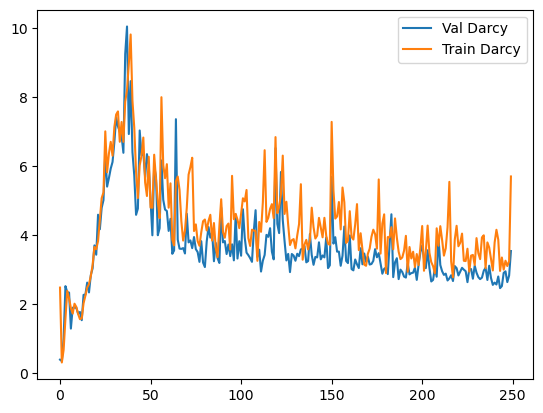

In [17]:
data = np.load("curves_disks_n8_r3_noise0.npz")
train_total = data["train_total"]
train_darcy = data["train_darcy"]
val_total   = data["val_total"]
val_darcy   = data["val_darcy"]

plt.plot(val_darcy, label="Val Darcy")
plt.plot(train_darcy, label="Train Darcy")
plt.legend()
plt.show()

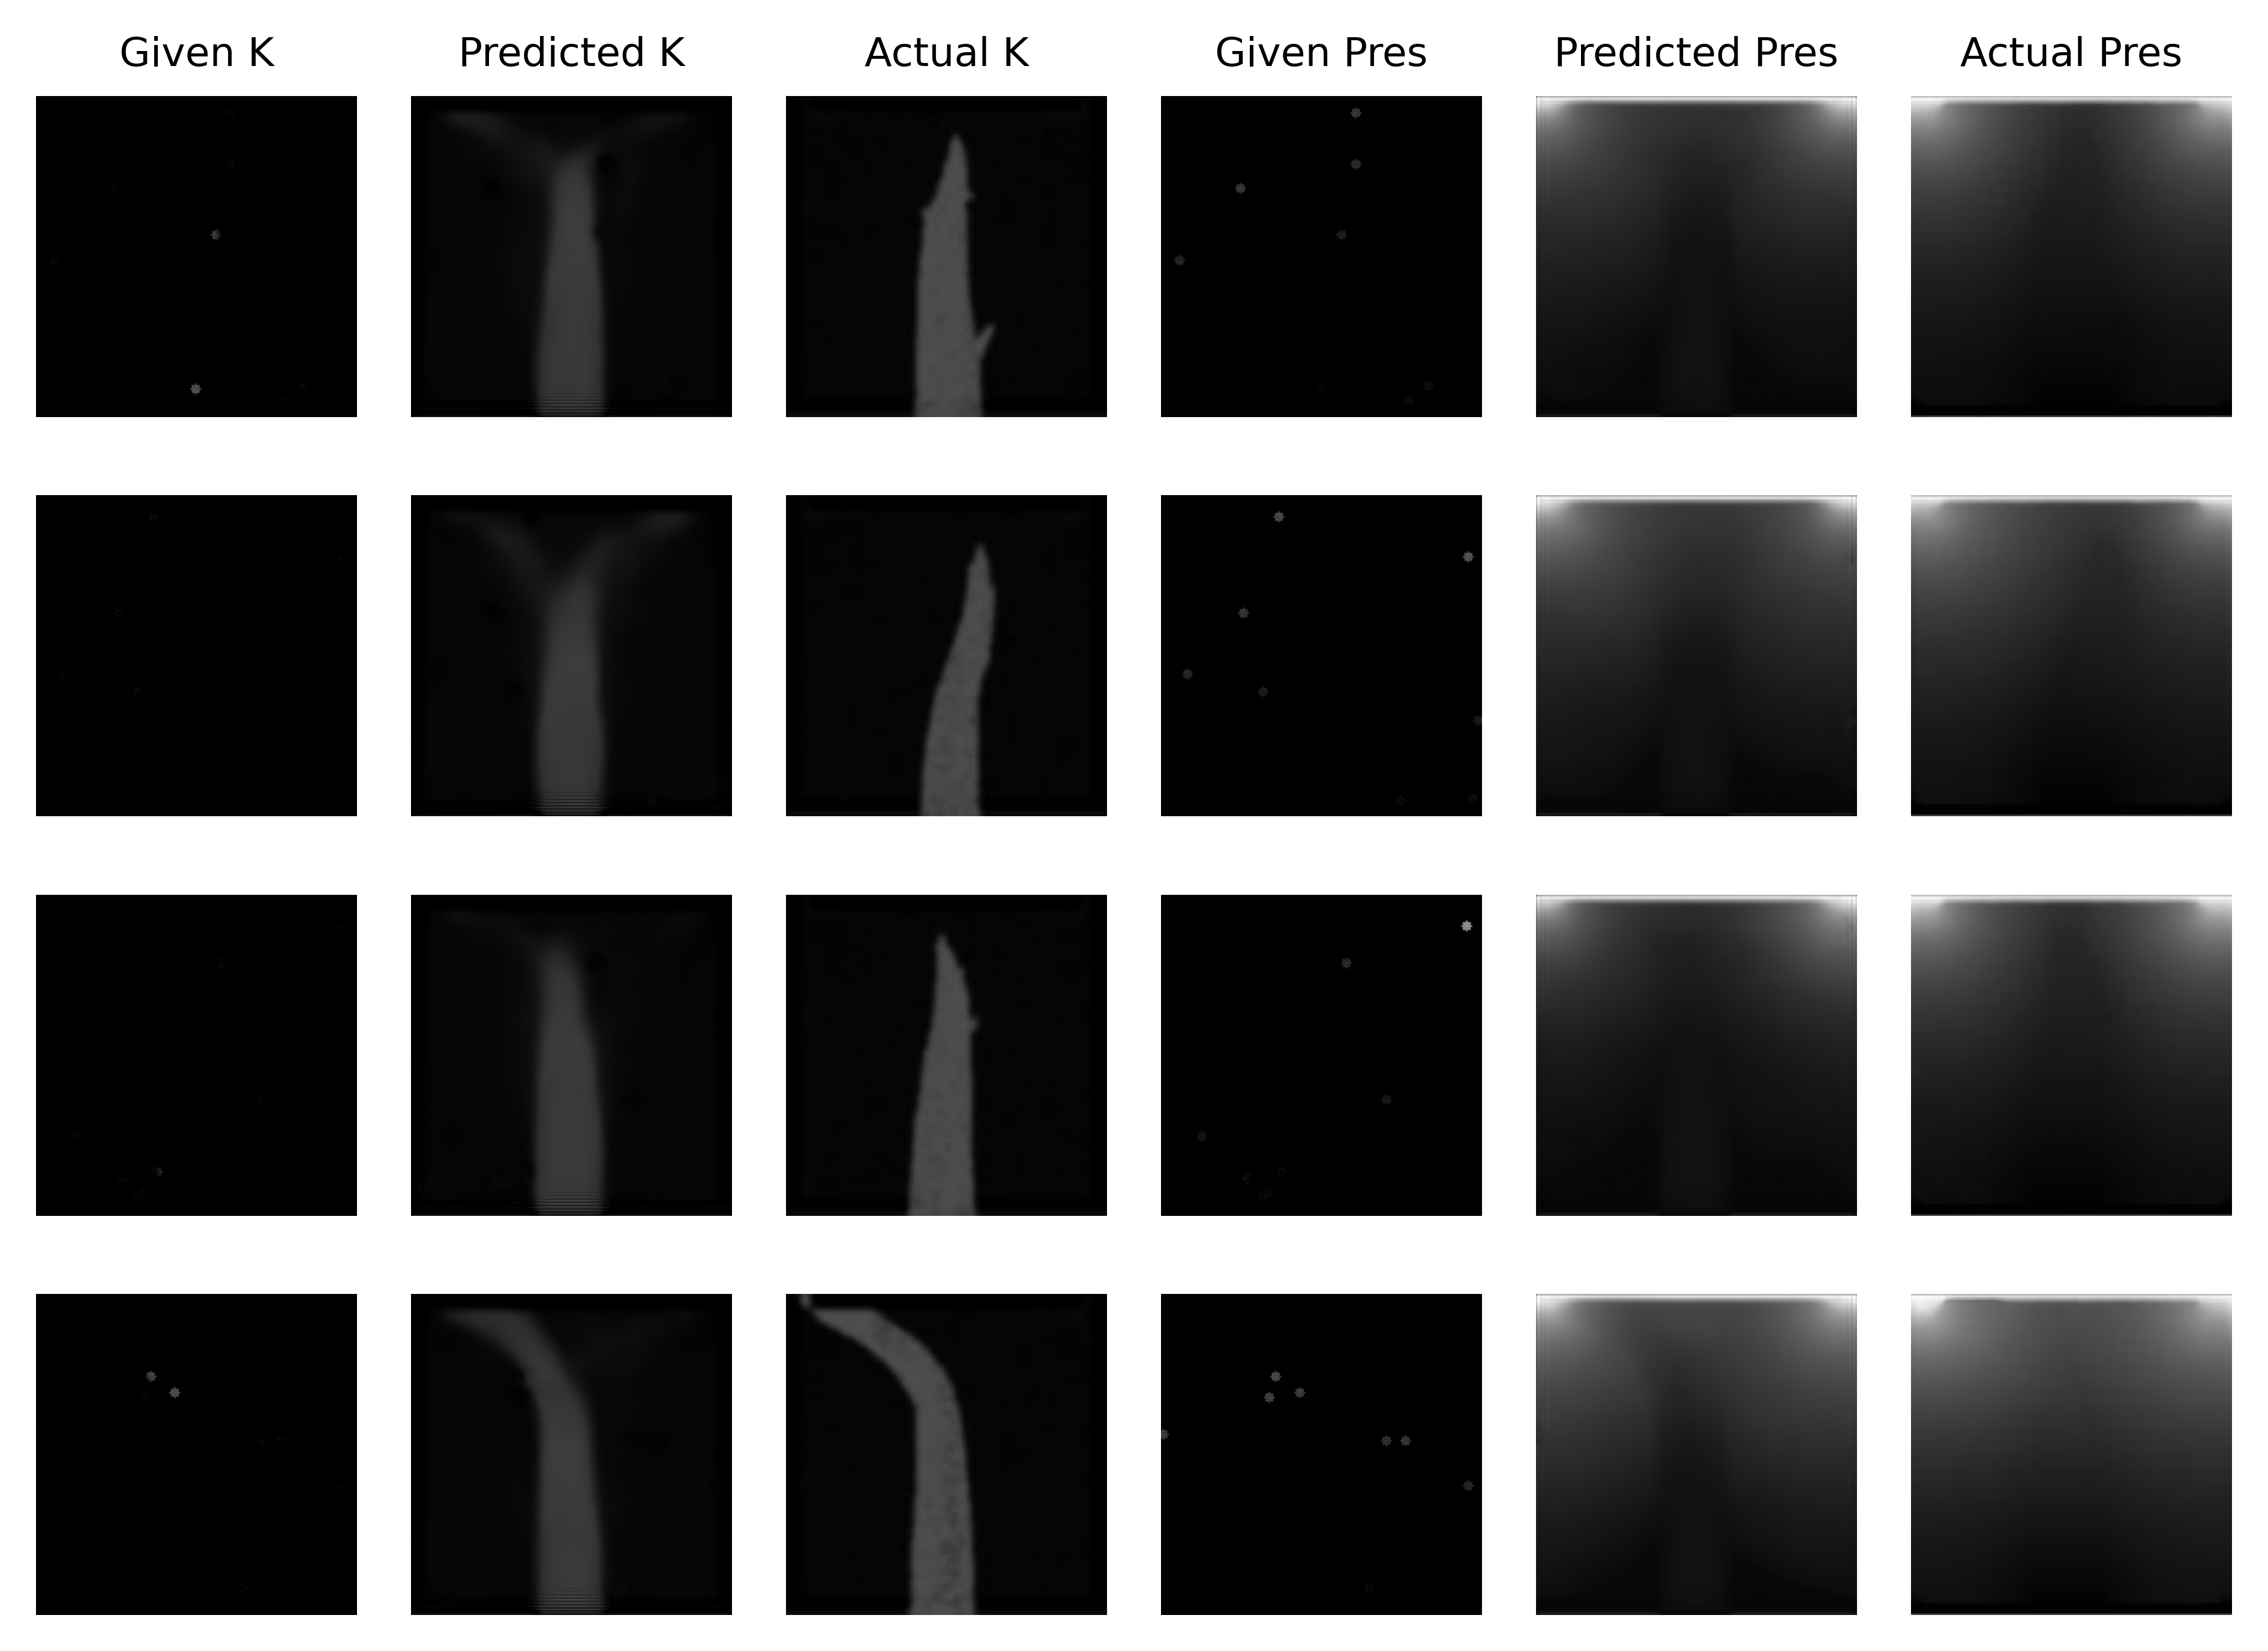

In [36]:
# load curves
cur = np.load("curves_disks_n8_r3_noise5.npz")
train_total = cur["train_total"]; train_darcy = cur["train_darcy"]
val_total   = cur["val_total"];   val_darcy   = cur["val_darcy"]

# load meta
meta = np.load("meta_disks_n8_r3_noise5.npz", allow_pickle=True)
reveal_strategy = str(meta["reveal_strategy"])
n_points = int(meta["n_points"]); radius = int(meta["radius"]); noise = float(meta["noise"])
channels = str(meta["channels"])
val_steps  = meta["val_steps"]
val_points = meta["val_points"]

# fix RNG before building val_data
torch.manual_seed(123); np.random.seed(123)

# rebuild val_data
val_data = MaskedDataset(
    val_sims,
    reveal_strategy=reveal_strategy,
    n_points=n_points,
    radius=radius,
    noise=noise,
    channels=channels,
    points=val_points,
    steps=val_steps
)

# load model + visualize
model = torch.load("disks_n8_r3_noise5.pt", weights_only=False, map_location=torch.device("cpu")).to(device)
model.eval()
show_evaluation(model, [9,2,12,17], val_data)